# <font color=darkcyan> Logistic regression</font>

In [45]:
# ignore warnings for better clarity (may not be the best thing to do)...
import warnings
warnings.filterwarnings('ignore')

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [47]:
# Required packages
np.set_printoptions(precision=2) 
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn
from numpy.linalg import norm
from scipy.optimize import check_grad
import seaborn as sns
import types

### <font color=darkred>  Model </font>

$\rightharpoondown$ The objective is to predict the  label $Y\in\{0,1\}$ based on $X\in\mathbb{R}^d$.

$\rightharpoondown$ Logistic regression models the distribution of $Y$ given $X$.

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(\langle w,X \rangle)\,,
\end{equation*}
where $w \in \mathbb{R}^d$ is a vector of model weights, and where $\sigma$ is the sigmoid function.

$$
\sigma: z \mapsto \frac{1}{1 + e^{-z}}\,.
$$

$\rightharpoondown$ The sigmoid function is a model choice to map $\mathbb{R}$ into $(0,1)$.


In [60]:
def sigmoid(x):
    expx = np.exp(x)
    z   = expx / (1. + expx)
    return z

def sample_logistic(w0, n_samples=1000, corr=0.5):
    n_features = w0.shape[0]
    cov        = toeplitz(corr ** np.arange(0, n_features))
    X          = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p          = sigmoid(X.dot(w0))
    y          = np.random.binomial(1, p, size=n_samples)
    return X, y

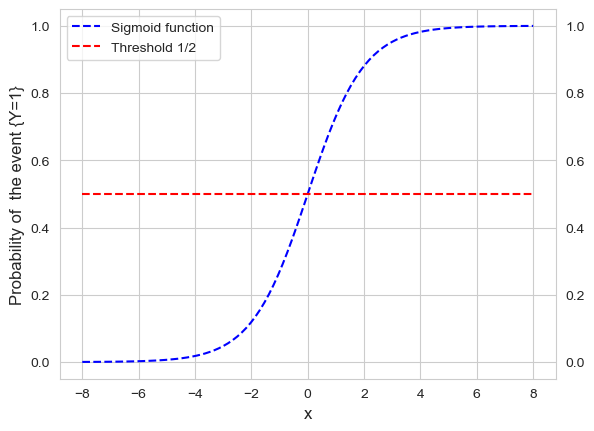

In [61]:
x = np.linspace(-8,8,100)
z = sigmoid(x)
plt.plot(x,z,linestyle = "dashed",color="blue", label= "Sigmoid function")
plt.plot(x,.5*np.ones(np.size(x)),linestyle = "dashed",color="red", label="Threshold 1/2")
plt.ylabel('Probability of  the event {Y=1}', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.tick_params(labelright=True)
plt.grid('True')
plt.legend();

Logistic regression models the distribution of $Y$ given $X$.

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(\langle w,X \rangle)\,,
\end{equation*}

The graph above illustrates that the Bayes classification rule in this case is
$f^*(X) = 1$ if and only if $\langle w,X \rangle>0$.

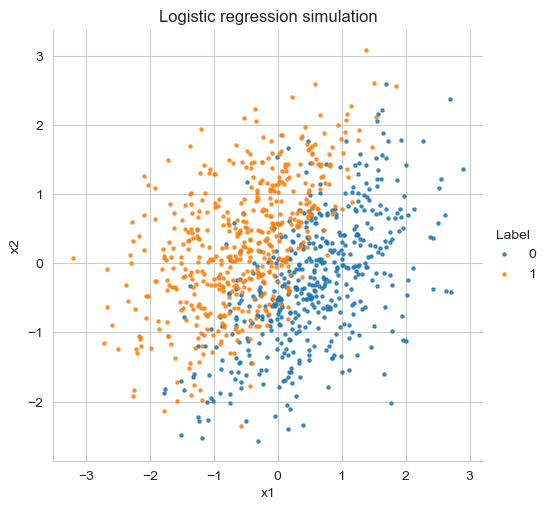

In [98]:
n_samples  = 1000
n_features = 2

w0   = multivariate_normal([-2,1], np.eye(2))

X, y = sample_logistic(w0, n_samples=n_samples, corr = 0.3)

simulated_data          = pd.DataFrame(columns = ["x","y","Label"])
simulated_data["x1"]     = X[:,0]
simulated_data["x2"]     = X[:,1]
simulated_data["Label"] = y

sns.set_style("whitegrid")
sns.lmplot(x = "x1", y = "x2", data = simulated_data, fit_reg = False, hue = "Label", legend = True, scatter_kws={"s": 5})

plt.title("Logistic regression simulation");

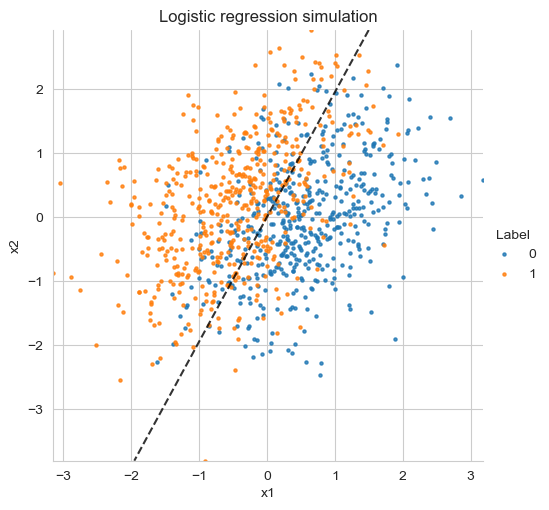

In [63]:
def decision_function(X,w):
    z = sigmoid(X.dot(w))
    return z
    
xlim  = [np.min(X[:,0]), np.max(X[:,0])]
ylim  = [np.min(X[:,1]), np.max(X[:,1])]
xplot = np.linspace(xlim[0], xlim[1], 30)
yplot = np.linspace(ylim[0], ylim[1], 30)

Yplot, Xplot = np.meshgrid(yplot, xplot)
xy           = np.vstack([Xplot.ravel(), Yplot.ravel()]).T
P            = decision_function(xy,w0).reshape(Xplot.shape)

sns.set_style("whitegrid")
sns.lmplot(x = "x1", y = "x2", data = simulated_data, fit_reg = False, hue = "Label", legend = True, scatter_kws={"s": 5})

plt.title("Logistic regression simulation");

# plot decision boundary and margins
plt.contour(Xplot, Yplot, P, colors = 'k', levels = [0.5], alpha = 0.8, linestyles = ['--']);

### <font color=darkred>  Logistic regression: losses and gradients </font>

The aim of this section is to detail how to solve the following optimization problem
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}\,,
$$
where $d$ is the number of features.

$$
f: w \mapsto \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \{-y_ix^\top_iw + \log(1 + \exp(x_i^\top w))\} + \frac{\lambda}{2} \|w\|_2^2\,,
$$
where $n$ is the sample size, and where $y_i \in \{ 0, 1 \}$ for all $1\leqslant i\leqslant n$.
 
A basic gradient descent algorithm requires to compute the functions $f$ and $\nabla f$.

<font color=darkred>  Write the likelihood of the logistic regression model and its gradient. You can build a class Logistic Regression which allows to compute the loss function and its gradient.</font>

In [73]:
class LogisticRegression:
    def __init__(self, X, y, lmbd):
        self.X = X
        self.y = y
        self.lmbd = lmbd
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        # Computes f(w)
    
    def grad(self, w):
        # Computes the gradient of f at w 

In [74]:
# Check numerically the gradient using the function checkgrad from scipy.optimize
# Use the function simu_logreg to simulate data according to the logistic regression model
n_features = 5
w_true     = np.random.randn(n_features)
X, y       = sample_logistic(w_true, n_samples, corr=0.1)
model      = LogisticRegression(X, y, 1e-3)
# check_grad assesses the correctness of a gradient by comparing it to a finite-difference approximation
check_grad(model.loss, model.grad, w_true)

4.5153998381991274e-08

### <font color=darkred> Gradient descent </font>

In the case of machine/deep learning applications, the function to be minimized is of the form:
$$
f:w\mapsto  \frac{1}{n}\sum_{i=1}^n \ell(Y_i, \langle w; X_i \rangle) + \lambda g(w) = \frac{1}{n}\sum_{i=1}^n f_i(w)\,.
$$
The most simple method  is based on full gradients, since at each iteration  it requires to compute
$$
\nabla f(w) = \frac 1n \sum_{i=1}^n \nabla  f_i(w)\,,
$$
which depends on the whole dataset. When processing very large datasets ($n$ is large), this approach has a highly prohibitive computational cost  for a  unique step towards the minimum. 
For all $k\geqslant 1$, set
$$
w^{(k)} = w^{(k-1)} - \eta_k \nabla f_{}(w^{(k-1)})\,.
$$
Each iteration has complexity $O(nd)$.

<font color=darkred>  Write a gradient descent function with inputs: a logistic regression model, an initial estimate, and a maximum number of iterations and a step-size.</font>

In [79]:
def gd(model, w0, n_iter,step):
    # update w and the list of loss
    return w, loss_val

<font color=darkred>  Run the algorithm and display the loss along iterations. Display the impact of the choice of the stepsize.</font>

In [80]:
step_sgd   = 1e-1
w0         = np.random.randn(n_features)
n_iter_max = 500

w, gd_loss  = gd(model, w0, n_iter = n_iter_max, step = step_sgd)

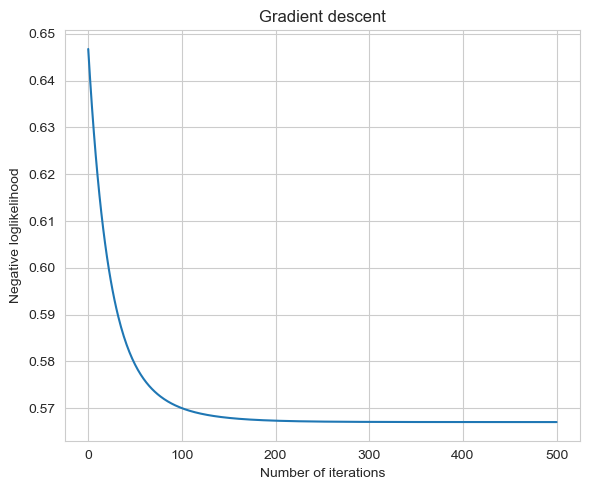

In [81]:
figure = plt.figure(figsize = (6, 5))
plt.plot(gd_loss, '-')
plt.title('Gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()

<font color=darkred>  Adapt the previous gradient descent algorithm to design a stochastic gradient descent with inputs: a logistic regression model, an initial estimate, and a maximum number of iterations, a constant c and a rate alpha (the stepsize at iteration $k$ is $\mathrm{c}/k^\alpha$).</font>

In [13]:
def grad_fi(self, i, w):
    # Computes the gradient of f_i at w

In [15]:
def sgd(model, w0, n_iter, c, alpha):  
    # update w and the list of loss

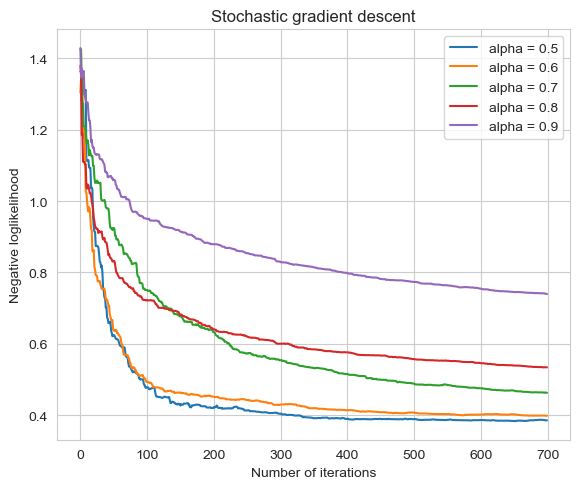

In [16]:
figure = plt.figure(figsize = (6, 5))
plt.title('Stochastic gradient descent')
plt.xlabel('Number of iterations')
plt.ylabel('Negative loglikelihood')
plt.tight_layout()

step_gd = [1e-2,1e-1,5e-1,1,2]
stp     = 0.5
alpha   = [0.5,0.6,0.7,0.8,0.9]
w0 = np.random.randn(n_features)
n_iter_max = 700
for al in alpha:
    w, sgd_loss = sgd(model, w0,n_iter_max, stp, al)
    plt.plot(sgd_loss, '-', label='alpha = %.1f' % al)
plt.legend()

### <font color=darkred> ROC curve and AUC</font>

In [17]:
n_test = int(0.2*n_samples)
X_test, y_test = sample_logistic(w_true, n_samples = n_test, corr = 0.8)

In [2]:
# predicted class using the estimated model


In [19]:
# predicted probability for each new individual using the estimated model


The Receiver Operating Characteristic (ROC) curve assesses the diagnostic ability of the classifier  as the classification threshold is modified. Logistic regression models the distribution of $Y$ given $X$ as

\begin{equation*}
\mathbb{P}(Y = 1| X) = \sigma(\langle w,X \rangle + b)\,,
\end{equation*}

and the Bayes classifier is defined as 

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) > \mathbb{P}(Y = 0| X)$,

which is equivalent to 

$f^*(X) = 1$ if and only if $\langle w,X \rangle + b>0$,

or also to 

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) >1/2$. 

Therefore, the theoretical threshold to classify individuals is $1/2$. However, analyzing the sensitivity of the classifier to this threshold may be interesting which is the aim of the ROC curve which displays the True positive rate as a function of the False positive rate when the threshold is changed. For each value $p^*\in(0,1)$ the ROC curve classifies individuals using

$f^*(X) = 1$ if and only if $\mathbb{P}(Y = 1| X) > p^*$

and plots the True positive rate as a function of the False positive rate. 

Depending on the application, an optimal threshold may then be used to obtain satisfying True and False positive rates on the test data set.

<font color=darkred>  Use the roc_curve metric from sklearn to display the ROC curve of your logistic regression model.</font>

In [20]:
from sklearn import metrics

array([ inf, 0.98, 0.96, 0.96, 0.94, 0.94, 0.93, 0.92, 0.91, 0.91, 0.91,
       0.89, 0.86, 0.86, 0.86, 0.86, 0.85, 0.84, 0.83, 0.82, 0.82, 0.79,
       0.77, 0.77, 0.76, 0.75, 0.73, 0.71, 0.71, 0.71, 0.68, 0.68, 0.67,
       0.67, 0.67, 0.64, 0.63, 0.63, 0.56, 0.55, 0.52, 0.52, 0.51, 0.51,
       0.49, 0.47, 0.46, 0.46, 0.45, 0.45, 0.42, 0.4 , 0.39, 0.39, 0.39,
       0.38, 0.37, 0.37, 0.35, 0.35, 0.34, 0.33, 0.33, 0.32, 0.32, 0.32,
       0.3 , 0.29, 0.29, 0.24, 0.23, 0.2 , 0.2 , 0.19, 0.19, 0.19, 0.17,
       0.17, 0.15, 0.14, 0.14, 0.12, 0.12, 0.02])

## <font color=darkred> Softmax regression </font>

Logistic regression can be extended to classify data in more than two groups. Softmax regression provides a model for the probability that an input $x$ is associated with each group.  It is assumed that the probability to belong to the class $k\in\{1,\ldots,M\}$ can be expressed by 
\begin{equation*}
\mathbb{P}(Y = k| X) = \frac{\exp(\langle w_k,X \rangle + b_k)}{\sum_{\ell=1}^{M}\exp(\langle w_\ell,X \rangle + b_\ell)} = p_k(X)\,,
\end{equation*}
where $w_\ell \in \mathbb{R}^d$ and $b_\ell$  are model \textbf{weights} and \textbf{intercepts} for each class.


To estimate these unknown parameters, a maximum likelihood approach is used as in the logistic regression setting. In this case, the loss function is given by the negative log-likelihood.